In order to decide k_max, let us calculate the steady state first
After seetting up Lagrange problem, we have first order conditions as

\begin{equation*}
\begin{aligned}
&(c_t-\frac{l_t^{1+\theta}}{1+\theta})^{-\gamma} = \lambda_t\\
&(c_t-\frac{l_t^{1+\theta}}{1+\theta})^{-\gamma}l_t^{\theta} = \lambda_tA_t(\frac{k_t}{l_t})^{\alpha}(1-\alpha)\\
&\lambda_t[e^{-\epsilon \gamma}+\phi(k_{t+1}-k_{t})] = \lambda_{t+1}\beta[A_{t+1} \theta k_{t+1}^{\theta-1} l_{t+1}^{1-\theta} + e^{-\epsilon \gamma}(1-\delta)+\phi(k_{t+2}-k_{t+1})]\end{aligned}
\end{equation*}

With the first order conditions, the optimal labor should satisfy

\begin{equation*}
\begin{aligned}
&(l_{t})^{\theta} = A_t\left(\frac{k_t}{l_t}\right)^{\alpha} (1-\alpha)
\end{aligned}
\end{equation*}



# 1. Functions

In [6]:
class Parameters:
    def __init__(self, A, alpha, theta, delta, beta, gamma, fi):
        '''
        A: TFP
        alpha: capital share in output
        delta: depreciation rate
        beta: discount factor
        fi: capital adjustment cost
        '''
        self.A = A 
        self.theta = theta
        self.alpha = alpha
        self.delta = delta
        self.beta = beta
        self.gamma = gamma
        self.fi = fi

In [7]:
# Utility function
def u(c,l, self):
    if c>0:
        return (c-(l**(1+self.theta))/(1+self.theta))**(1-self.gamma)/(1-self.gamma)
    else:
        return (-np.inf)

# Production function
def F(K, L, self):
    return self.A* (K**(self.alpha)) * (L**(1 - self.alpha))

#def l_optimal
def optimal_labor(K, self):
    return (self.A*(1 - self.alpha)*K**(self.alpha))**(1/(self.theta + self.alpha))

def consumption(K0, K1, l, epsilon, self):
    return F(K0, l, self) - (K1 - (1 - self.delta) * K0 )*np.exp(-epsilon) - (self.fi/2)*((K1 - K0)**(2))
    


In [8]:
def bellman_operator(v, k_grid, epsilon_values, pi, params, compute_policy=True):
    """
    Modified Bellman operator to use external functions
    """
    len_k = len(k_grid)
    len_e = len(epsilon_values)
    
    # define the initial value and policy function
    k_policy = np.zeros((len_e, len_k), dtype=int)
    v_new = np.zeros_like(v)

    for e_i in range(len_e):
        e = epsilon_values[e_i]
        for k_i in range(len_k):
            k = k_grid[k_i]
            l_op = optimal_labor(k, params)  # 使用外部函数

            v_max = -np.inf
            for i in range(len_k):
                c = consumption(k, k_grid[i], l_op, e, params)  # 使用外部函数
                if (c - (l_op**(1+params.theta))/(1+params.theta)) > 0:
                    v_tem = u(c, l_op, params) + params.beta * np.sum(pi[e_i]*v[:,i])  # 使用外部函数
                    if v_tem > v_max:
                        k_policy[e_i, k_i] = i
                        v_new[e_i, k_i] = v_tem
                        v_max = v_tem
                        
    if compute_policy:
        return v_new, k_policy
    return v_new

def value_func_iteration(v_guess, k_grid, epsilon_values, pi, params, max_itr=5000, tol=1e-5):
    """
    Value function iteration main loop
    """
    v = v_guess
    error = 1
    itr = 1
    
    start_time = time.time()
    
    while error > tol and itr < max_itr:
        v_update, k_policy = bellman_operator(v, k_grid, epsilon_values, pi, params)
        error = np.max(np.abs(v - v_update))
        v = v_update
        itr += 1
    
    end_time = time.time()
    time_used = end_time - start_time
    print(f"Number of iterations: {itr}")
    print(f"Time used: {time_used:.4f} seconds")
    print("Final Value Function:")
    print(v)
    print("\nPolicy Function (Optimal Capital Choices):")
    print(k_policy)

    return v, k_policy


# Answers

In [9]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [10]:
params = Parameters(
    A=1.0,      # TFP
    alpha=0.33,  # capital share
    theta=1.0,   # labor elasticity
    delta=0.07,  # depreciation rate
    beta=0.96,   # discount factor
    gamma=2.0,   # risk aversion
    fi=0.06      # capital adjustment cost
)

In [11]:
# Initialize value function (for each state of z)
k_min = 0.5
k_max = 10
n_k = 50
epsilon_values = [-0.06, -0.02, 0.02, 0.06]
pi = ([
    [0.80, 0.12, 0.06, 0.02],
    [0.07, 0.84, 0.07, 0.02],
    [0.02, 0.07, 0.84, 0.07],
    [0.02, 0.06, 0.12, 0.80]
])
e_size = len(epsilon_values)
tol = 1e-5
max_itr = 5000
v = np.zeros((len(epsilon_values), n_k))
k_grid = np.linspace(k_min , k_max , n_k)

In [12]:
v_guess = np.zeros((len(epsilon_values), n_k))
v_star, k_policy = value_func_iteration(v_guess, k_grid, epsilon_values, pi, params)

Number of iterations: 292
Time used: 5.8957 seconds
Final Value Function:
[[-54.43838126 -49.50914453 -46.36868347 -44.07119146 -42.26476334
  -40.77945697 -39.51993176 -38.42712886 -37.46173656 -36.59606362
  -35.80963285 -35.08658787 -34.414043   -33.78714004 -33.20700457
  -32.66670623 -32.16046403 -31.68336428 -31.23510719 -30.81371658
  -30.41572919 -30.0383867  -29.6841108  -29.3501382  -29.03395918
  -28.7357512  -28.45691769 -28.19583059 -27.95105108 -27.72130229
  -27.50168415 -27.28570384 -27.07440521 -26.86858315 -26.66858165
  -26.47406513 -26.28483331 -26.10077095 -25.92166637 -25.74727528
  -25.57741823 -25.41196191 -25.25080549 -25.09386096 -24.94101551
  -24.79217256 -24.64724828 -24.50616876 -24.36886771 -24.23528469]
 [-53.58342793 -48.93843994 -45.9234612  -43.69721895 -41.93715499
  -40.48492684 -39.25083724 -38.17905437 -37.23242683 -36.38498196
  -35.61787687 -34.91706868 -34.27191678 -33.67382553 -33.11521768
  -32.58971661 -32.09180539 -31.61656241 -31.16789767 

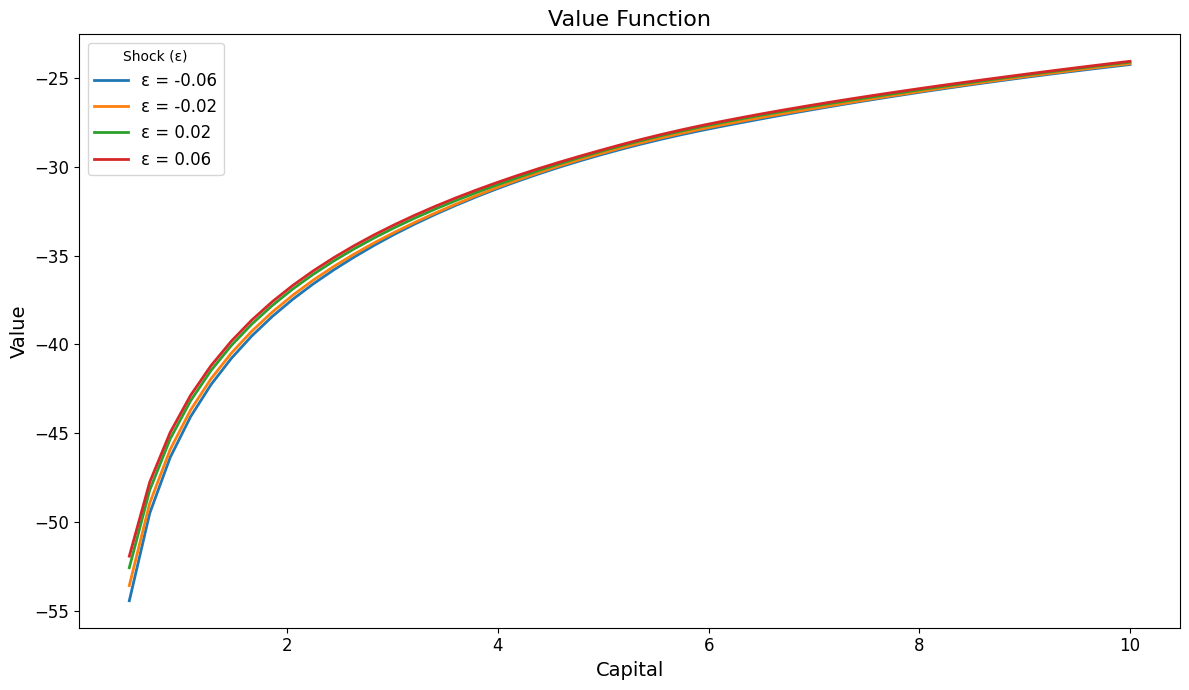

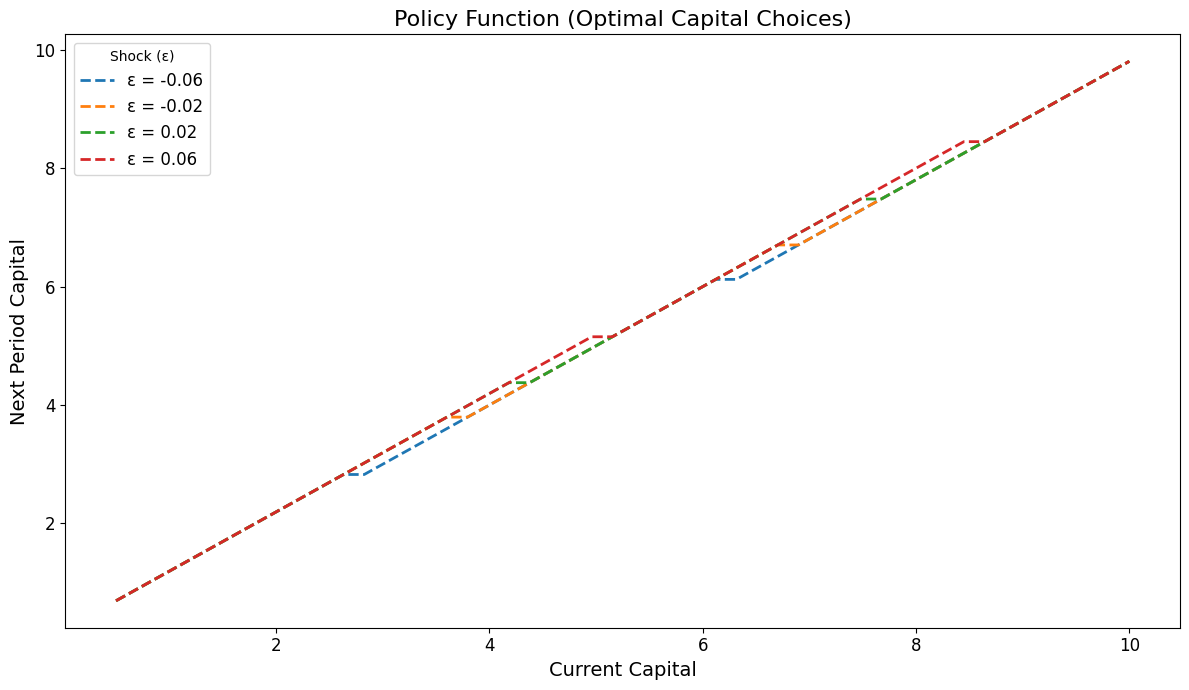

In [13]:
#plot value function
plt.figure(figsize=(12, 7))
for i, epsilon in enumerate(epsilon_values):
    plt.plot(k_grid, v_star[i, :], label=f'ε = {epsilon}', linewidth=2)
plt.title('Value Function', fontsize=16)
plt.xlabel('Capital', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(title="Shock (ε)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# plot policy function
plt.figure(figsize=(12, 7))
for i, epsilon in enumerate(epsilon_values):
    plt.plot(k_grid, k_grid[k_policy[i, :]], label=f'ε = {epsilon}', linewidth=2, linestyle='--')
plt.title('Policy Function (Optimal Capital Choices)', fontsize=16)
plt.xlabel('Current Capital', fontsize=14)
plt.ylabel('Next Period Capital', fontsize=14)
plt.legend(title="Shock (ε)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()